In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split, DataLoader

np.random.seed(41)



In [56]:
x = pd.read_csv('/content/drive/MyDrive/GP_Dataset/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/GP_Dataset/y_train.csv')
x=x.drop(columns=['accEulerPitch'	,'accEulerRoll' ,'gyroEulerPitch',
                  'gyroEulerRoll'	,'gyroEulerYaw' ,'magEulerYaw',	'magX',
                  'magY',	'magZ','gyroPitch', 'gyroRoll', 'gyroYaw'])


FEATURE_COLUMNS=[
 'SpeedOverGround',
 'accX',
 'accY',
 'accZ',
 'filteredPitch',
 'filteredRoll',
 'filteredYaw',
 ]
window_sz=69

In [57]:
x.head()

,accX,accY,accZ,filteredPitch,filteredRoll,filteredYaw,SpeedOverGround,sessionID,seriesID,MeasurmentIndex
0,0.09088,-0.04079,0.97609,-7.963299,0.192753,0.022188,0.194,1,1.0,1
1,-0.02312,-0.03479,1.02309,-14.800236,0.125354,0.054233,0.194,1,1.0,2
2,0.02788,-0.08179,1.02409,-20.465674,0.167955,0.099281,0.194,1,1.0,3
3,-0.01412,-0.07579,0.99409,-25.373428,0.122643,0.124763,0.194,1,1.0,4
4,-0.00712,-0.06479,0.97609,-29.646640,0.111226,0.115184,0.194,1,1.0,5


In [58]:
x.shape

(52851, 10)

In [59]:
y.head()

,sessionID,seriesID,Latitude,Longitude,Manual Cluster
0,1,1.0,31.434961,31.677570,0
1,1,2.0,31.434953,31.677572,1
2,1,3.0,31.434938,31.677577,1
3,1,4.0,31.434916,31.677584,0
4,1,5.0,31.434879,31.677599,0


In [60]:
y.shape

(775, 5)

In [61]:
# Group by 'seriesID' and extract values
grouped_features = x.groupby('seriesID')[FEATURE_COLUMNS].apply(lambda df: df.values)
grouped_labels = y.groupby('seriesID')["Manual Cluster"].apply(lambda df: df.values)


In [62]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [63]:
processed_features = []
processed_labels = []

for seq, labels in zip(grouped_features, grouped_labels):
    if len(seq) < window_sz:
        # Pad shorter sequences
        padded_seq = pad_sequences([seq], maxlen=window_sz, dtype='float32', padding='post')[0]
        processed_features.append(padded_seq)

        # Assign the same label to the entire sequence (first label in the sequence)
        processed_labels.append(labels[0])

    else:
        # Apply sliding window for longer sequences
        for i in range(len(seq) - window_sz + 1):
            processed_features.append(seq[i:i + window_sz])

            # Use the **first label** of the sequence for all windows
            processed_labels.append(labels[0])

# Convert to NumPy arrays
feat_array = np.array(processed_features)
y_array = np.array(processed_labels)

In [64]:
assert len(feat_array) == len(y_array), "Mismatch: labels and features are not aligned!"


In [65]:
feat_array.shape

(982, 69, 7)

In [66]:
x.head(140)

,accX,accY,accZ,filteredPitch,filteredRoll,filteredYaw,SpeedOverGround,sessionID,seriesID,MeasurmentIndex
0,0.09088,-0.04079,0.97609,-7.963299,0.192753,0.022188,0.194,1,1.0,1
1,-0.02312,-0.03479,1.02309,-14.800236,0.125354,0.054233,0.194,1,1.0,2
2,0.02788,-0.08179,1.02409,-20.465674,0.167955,0.099281,0.194,1,1.0,3
3,-0.01412,-0.07579,0.99409,-25.373428,0.122643,0.124763,0.194,1,1.0,4
4,-0.00712,-0.06479,0.97609,-29.646640,0.111226,0.115184,0.194,1,1.0,5
...,...,...,...,...,...,...,...,...,...,...
135,0.01888,-0.07479,0.89709,79.723919,-3.353172,-32.767100,4.425,1,3.0,13
136,-0.05712,0.15321,1.19609,81.269667,-2.572680,-31.218199,4.425,1,3.0,14
137,0.00988,0.01321,0.70909,82.652983,-4.390029,-32.373466,4.425,1,3.0,15
138,0.00188,-0.03879,0.74909,84.144035,-3.035080,-30.294546,4.425,1,3.0,16


In [67]:
y.head()

,sessionID,seriesID,Latitude,Longitude,Manual Cluster
0,1,1.0,31.434961,31.677570,0
1,1,2.0,31.434953,31.677572,1
2,1,3.0,31.434938,31.677577,1
3,1,4.0,31.434916,31.677584,0
4,1,5.0,31.434879,31.677599,0


In [68]:
df=pd.DataFrame(y_array)
df

,0
0,0
1,1
2,1
3,1
4,1
...,...
977,0
978,0
979,0
980,0


In [69]:
target_array = np.array(y_array)

In [70]:
def absfft(x):
    return np.abs(np.fft.rfft(x))

feat_fft_array = np.copy(feat_array[:,:,1:])#acc gyro
feat_fft_array = np.apply_along_axis(absfft,1,feat_fft_array)

In [71]:
feat_fft_array.shape

(982, 35, 6)

In [72]:
#Applying normalization across the entire dataset to ensure NN inputs are zero-mean and unit standard deviation

num_sensor = feat_array.shape[2]
for i in range(num_sensor):
    mean_s = np.mean(feat_array[:,:,i])
    sd_s = np.std(feat_array[:,:,i])
    feat_array[:,:,i] = (feat_array[:,:,i]-mean_s)/sd_s

num_sensor_fft = feat_fft_array.shape[2]
for i in range(num_sensor_fft):
    mean_s = np.mean(feat_fft_array[:,:,i])
    sd_s = np.std(feat_fft_array[:,:,i])
    feat_fft_array[:,:,i] = (feat_fft_array[:,:,i]-mean_s)/sd_s

In [73]:
feat_fft_array.shape,feat_array.shape,target_array.shape

((982, 35, 6), (982, 69, 7), (982,))

In [74]:
raw_arr = feat_array.transpose(0, 2, 1)
fft_arr = feat_fft_array.transpose(0, 2, 1)
target = target_array

In [75]:
raw_arr.shape,fft_arr.shape,target.shape

((982, 7, 69), (982, 6, 35), (982,))

In [76]:
0.8*len(raw_arr)

785.6

In [77]:
from sklearn.utils import shuffle
def create_datasets(data, target, train_size, valid_pct=0.2, seed=None):
    """Converts NumPy arrays into PyTorch datsets.

    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """

    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct)#, random_state=seed
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(),
        torch.tensor(fft[:sz][trn_idx]).float(),
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    return trn_ds, val_ds, tst_ds


In [78]:
def create_loaders(data, bs=64, jobs=2):  # Increased batch size to 64
    """Wraps the datasets returned by create_datasets function with data loaders."""

    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs, pin_memory=True)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs, pin_memory=True)
    return trn_dl, val_dl, tst_dl


In [79]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.

    The separable convlution is a method to reduce number of the parameters
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

In [80]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [81]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [82]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=0.3):  # Increased dropout to 0.3
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=35,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=drop  # Apply dropout in LSTM layers
        )

        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop)  # Dropout in classifier
        )

        self.raw = nn.Sequential(
            SepConv1d(raw_ni, 64, 10, 2, 3, drop=drop),
            SepConv1d(64, 128, 3, 4, 2, drop=drop),
            SepConv1d(128, 256, 3, 4, 2, drop=drop),
            SepConv1d(256, 512, 3, 4, 2),
            Flatten(),
            nn.Linear(1024, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )

        self.out = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(64, no)
        )

    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)

        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(t_fft)
        fft_out = hidden[-1]
        fft_out = self.classifier(fft_out)

        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out


In [83]:
train_size =982

datasets = create_datasets((raw_arr, fft_arr), target, train_size, seed=41)
# make sure that we run on a proper device (not relevant for Kaggle kernels but helpful in Jupyter sessions)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [84]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=35)

n_epochs = 400
iterations_per_epoch = len(trn_dl)
num_classes = 5
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []

In [85]:
model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss()# nn.CrossEntropyLoss(reduction='sum')
# Initialize optimizer and learning rate scheduler
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=1e-5, max_lr=1e-3, step_size_up=200, mode="triangular2")


In [86]:
from tqdm import tqdm  # Progress bar

# **Model Training Loop**

In [87]:
print("🚀 Start model training...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, n_epochs + 1):

    # Training phase
    model.train()
    epoch_loss = 0
    with tqdm(total=len(trn_dl), desc=f"Epoch {epoch}/{n_epochs}") as pbar:
        for i, batch in enumerate(trn_dl):
            x_raw, x_fft, y_batch = [t.to(device) for t in batch]

            opt.zero_grad()
            out = model(x_raw, x_fft)
            loss = criterion(out, y_batch)
            epoch_loss += loss.item()

            loss.backward()

            # Apply gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            opt.step()
            scheduler.step()  # Update learning rate dynamically

            pbar.update(1)

    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_dl:
            x_raw, x_fft, y_batch = [t.to(device) for t in batch]
            out = model(x_raw, x_fft)
            preds = F.log_softmax(out, dim=1).argmax(dim=1)
            total += y_batch.size(0)
            correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)

    # Print progress every `base` epochs
    if epoch % base == 0:
        print(f"📢 Epoch {epoch}: Loss = {epoch_loss:.4f}, Accuracy = {acc:.2%}")
        base *= step  # Increase interval

    # Save the best model
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), "best.pth")
        print(f"✅ New best model saved at epoch {epoch} with accuracy: {best_acc:.2%}")
    else:
        trials += 1
        if trials >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break

print("🎉 Training complete!")

🚀 Start model training...


Epoch 1/400: 100%|██████████| 23/23 [00:01<00:00, 13.46it/s]


📢 Epoch 1: Loss = 1.6148, Accuracy = 3.05%
✅ New best model saved at epoch 1 with accuracy: 3.05%


Epoch 2/400: 100%|██████████| 23/23 [00:01<00:00, 14.79it/s]


📢 Epoch 2: Loss = 1.4330, Accuracy = 85.79%
✅ New best model saved at epoch 2 with accuracy: 85.79%


Epoch 4/400: 100%|██████████| 23/23 [00:01<00:00, 22.37it/s]


📢 Epoch 4: Loss = 0.6543, Accuracy = 85.79%


Epoch 5/400: 100%|██████████| 23/23 [00:01<00:00, 21.81it/s]


✅ New best model saved at epoch 5 with accuracy: 86.80%


Epoch 6/400: 100%|██████████| 23/23 [00:01<00:00, 21.82it/s]


✅ New best model saved at epoch 6 with accuracy: 87.82%


Epoch 8/400: 100%|██████████| 23/23 [00:01<00:00, 22.29it/s]


📢 Epoch 8: Loss = 0.3054, Accuracy = 87.82%


Epoch 9/400: 100%|██████████| 23/23 [00:01<00:00, 20.80it/s]


✅ New best model saved at epoch 9 with accuracy: 89.34%


Epoch 10/400: 100%|██████████| 23/23 [00:01<00:00, 22.32it/s]


✅ New best model saved at epoch 10 with accuracy: 89.85%


Epoch 13/400: 100%|██████████| 23/23 [00:01<00:00, 17.89it/s]


✅ New best model saved at epoch 13 with accuracy: 90.86%


Epoch 16/400: 100%|██████████| 23/23 [00:01<00:00, 22.52it/s]


📢 Epoch 16: Loss = 0.1927, Accuracy = 90.86%


Epoch 25/400: 100%|██████████| 23/23 [00:01<00:00, 22.52it/s]


✅ New best model saved at epoch 25 with accuracy: 92.39%


Epoch 32/400: 100%|██████████| 23/23 [00:01<00:00, 22.24it/s]


📢 Epoch 32: Loss = 0.1718, Accuracy = 92.39%


Epoch 64/400: 100%|██████████| 23/23 [00:01<00:00, 19.64it/s]


📢 Epoch 64: Loss = 0.1192, Accuracy = 91.88%


Epoch 128/400: 100%|██████████| 23/23 [00:01<00:00, 19.21it/s]


📢 Epoch 128: Loss = 0.0952, Accuracy = 91.88%


Epoch 256/400: 100%|██████████| 23/23 [00:01<00:00, 18.75it/s]


📢 Epoch 256: Loss = 0.0893, Accuracy = 92.39%


Epoch 400/400: 100%|██████████| 23/23 [00:01<00:00, 18.23it/s]


🎉 Training complete!


In [88]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')*1.03
    return y_smooth

In [89]:
np.std(acc_history[2:])

np.float64(0.007428213626800403)

In [90]:
pd.DataFrame(loss_history).to_csv('loss.csv')
pd.DataFrame(acc_history).to_csv('acc.csv')

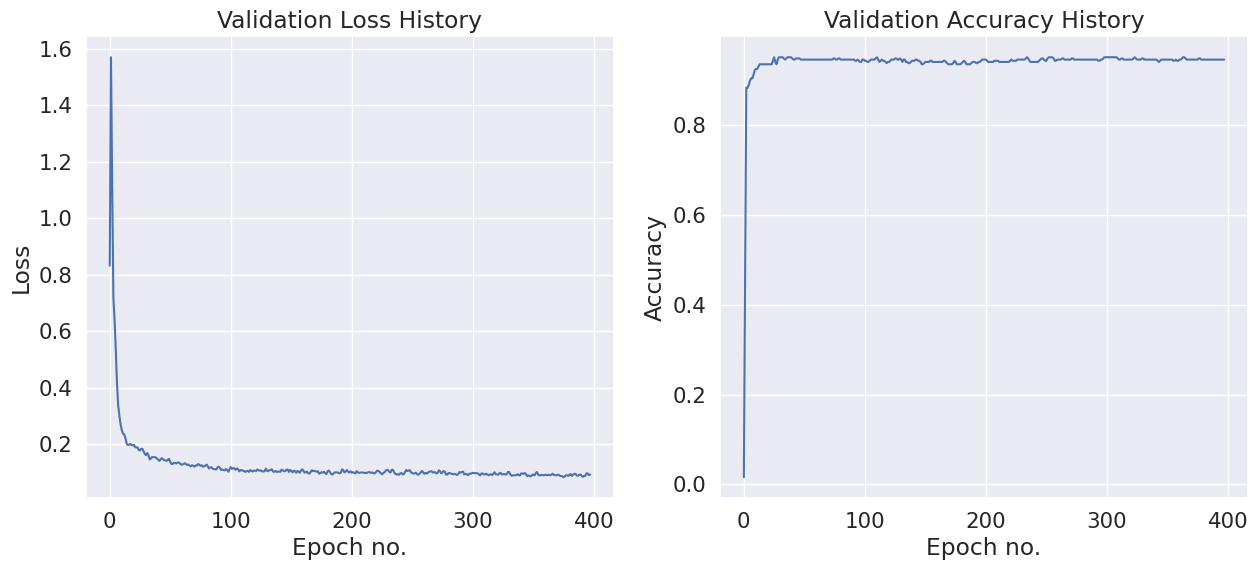

In [91]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(smooth(loss_history, 2)[:-2], label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')


ax[1].plot(smooth(acc_history, 2)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')
plt.show()

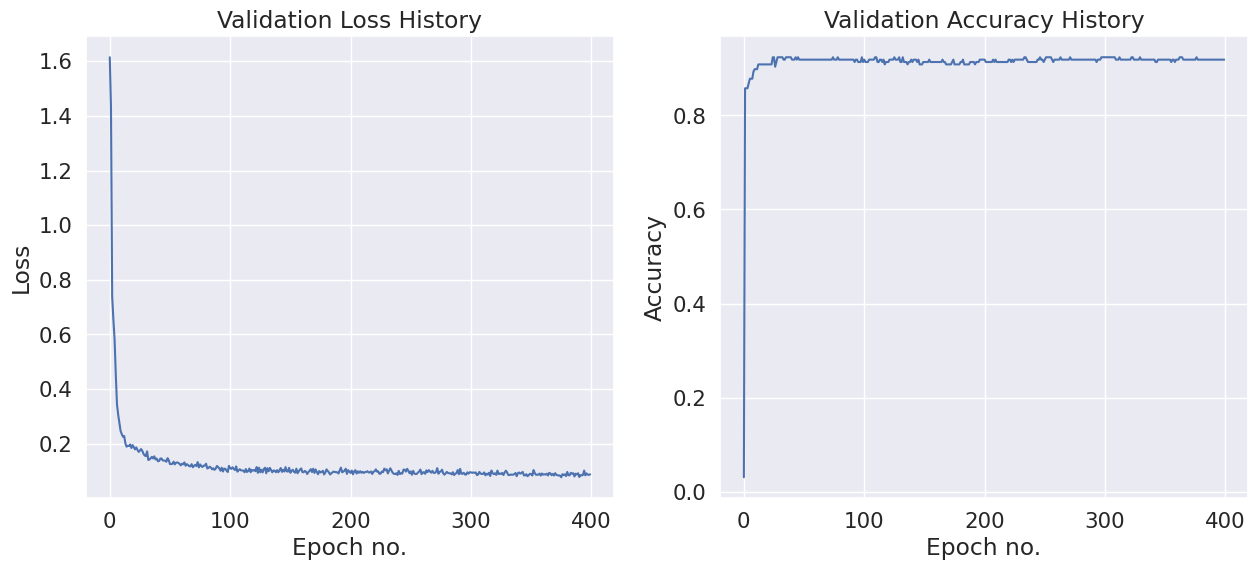

In [92]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(acc_history, label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')
plt.show()

In [93]:
test_results = []
labels= []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, label in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []
model.load_state_dict(torch.load('best.pth'))
model.eval()

for x_raw, x_fft, labels in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_pred.extend(y_hat.tolist())
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


# constant for classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix
df_cm=pd.DataFrame(cf_matrix)
df_cm

,0,1,2,3
0,165,0,4,0
1,1,4,1,0
2,4,1,13,0
3,4,0,0,0


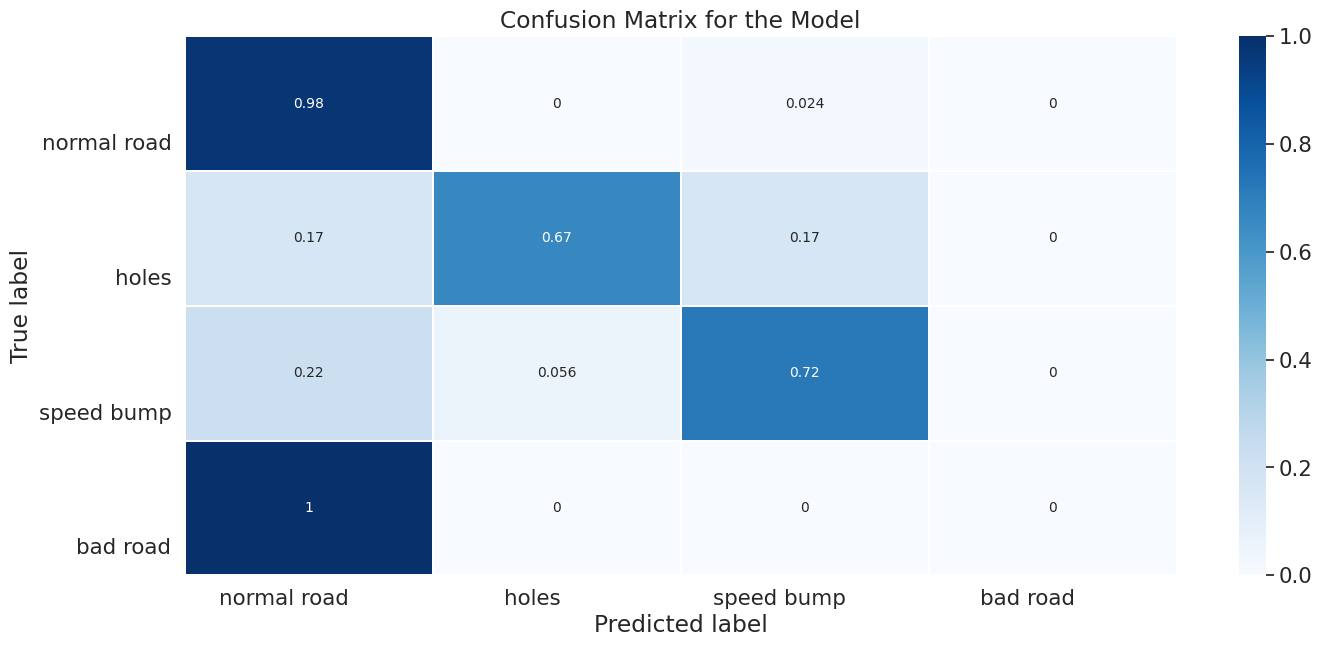

In [95]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['normal road', 'holes', 'speed bump',
               'bad road']
tick_marks = np.arange(4)+ 0.4
tick_marks2 = tick_marks + 0.4
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for the Model')
plt.show()

In [96]:
from sklearn.metrics import classification_report

print(    classification_report(y_true, y_pred)      )

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       169
           2       0.80      0.67      0.73         6
           3       0.72      0.72      0.72        18
           4       0.00      0.00      0.00         4

    accuracy                           0.92       197
   macro avg       0.62      0.59      0.60       197
weighted avg       0.90      0.92      0.91       197



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
!pip install fastapi uvicorn nest-asyncio pyngrok


In [98]:
torch.save(model.state_dict(), "DSC-BiLSTM_model.pth")


In [99]:
%%writefile app.py
from fastapi import FastAPI
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from pydantic import BaseModel

#  Define the model architecture (same as the trained model)
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=64, num_layers=2, batch_first=True, bidirectional=True, dropout=0.7)
        self.fc = nn.Linear(128, 64)
        self.out = nn.Linear(64, 4)  # Change 4 to match the number of classes

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        x = hidden[-1]
        x = F.relu(self.fc(x))
        x = self.out(x)
        return x

#  Load the trained model
model = Classifier()
model.load_state_dict(torch.load("DSC-BiLSTM_model.pth"))
model.eval()

#  Initialize FastAPI
app = FastAPI()

#  Define the Input Data Format
class InputData(BaseModel):
    features: list  # Expecting a list of 7 numerical features

#  Create the Prediction Endpoint
@app.post("/predict")
def predict(data: InputData):
    x_input = torch.tensor([data.features], dtype=torch.float32)
    with torch.no_grad():
        output = model(x_input)
        prediction = torch.argmax(output, dim=1).item()
    return {"prediction": prediction}




Overwriting app.py


In [100]:
!uvicorn app:app --host 127.0.0.1 --port 4040 &


Traceback (most recent call last):
  File "/usr/local/bin/uvicorn", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1161, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1082, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1443, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 788, in invoke
    return __callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 412, in main
    run(
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/usr/local/lib/python3.

In [101]:
!ngrok authtoken 2urcHr0OLGHyLsBQDlOTIFt3oVf_6bthE4EpnW1AaS6ruyywN


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [102]:
from pyngrok import ngrok

# Open a tunnel to expose port 4040
public_url = ngrok.connect(4040)
print(f"Public URL: {public_url}")


Public URL: NgrokTunnel: "https://a64e-35-245-127-131.ngrok-free.app" -> "http://localhost:4040"


In [103]:
!ps aux | grep ngrok

root       16473  0.3  0.2 1254748 30348 ?       Sl   21:02   0:02 /root/.config/ngrok/ngrok start -
root       25879  0.0  0.0   7376  3544 ?        S    21:14   0:00 /bin/bash -c ps aux | grep ngrok
root       25881  0.0  0.0   6484  2308 ?        S    21:14   0:00 grep ngrok


In [104]:




# Download the model
from google.colab import files
files.download("DSC-BiLSTM_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>